In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import datetime
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import math as m
from mlxtend.evaluate import permutation_test

In [5]:
def findWaldtest(p1, p2,var1, var2, n , m,):
    denominator = float(var1)/n + float(var2)/m
    denominator = np.sqrt(denominator)
    return abs(float(p1-p2)/denominator)

## Topic 1 : Delays and Cancellations

### Hypothesis 1: Shorter distance flights causes longer arrival delays

"1","Less Than 250 Miles" <br>
"2","250-499 Miles"<br>
"3","500-749 Miles"<br>
"4","750-999 Miles"<br>
"5","1000-1249 Miles"<br>
"6","1250-1499 Miles"<br>
"7","1500-1749 Miles"<br>
"8","1750-1999 Miles"<br>
"9","2000-2249 Miles"<br>
"10","2250-2499 Miles"<br>
"11","2500 Miles and Greater"<br>

In [4]:
data_3 = pd.DataFrame()
for i in range(1,13):
    data_3 = pd.concat([data_3 ,pd.read_csv('flight_delay_prediction/Data/555602239_T_ONTIME-'+str(i)+'.csv', delimiter =',')],axis =0)
data_3 = data_3.drop(['Unnamed: 29'],axis =1)
cols = ['ORIGIN_CITY_NAME','DEST_CITY_NAME', 'DISTANCE','DISTANCE_GROUP', 'DEP_DELAY', 'ARR_DELAY']
hyp_2data = data_3.loc[:,cols]

In [6]:
##Remove ouliers
new_hyp_2data = hyp_2data
q1_1 = new_hyp_2data['ARR_DELAY'].quantile(0.25)
q2_1 = new_hyp_2data['ARR_DELAY'].quantile(0.50)
q3_1 = new_hyp_2data['ARR_DELAY'].quantile(0.75)

limit1 = 1.5 * (q3_1-q1_1)  

new_hyp_2data = new_hyp_2data.loc[ (new_hyp_2data.ARR_DELAY > (q3_1 + limit1) ) |  
                                (new_hyp_2data.ARR_DELAY  < (q3_1 - limit1))]

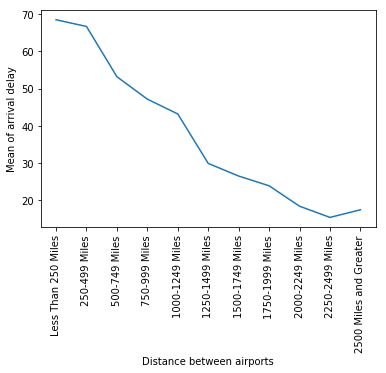

In [7]:
distance_vs_delay = new_hyp_2data.groupby(['DISTANCE_GROUP'])['ARR_DELAY'].mean().reset_index()

tic = ["Less Than 250 Miles","250-499 Miles", "500-749 Miles", "750-999 Miles", "1000-1249 Miles" ,
       "1250-1499 Miles" , "1500-1749 Miles" , "1750-1999 Miles" ,"2000-2249 Miles" , "2250-2499 Miles" ,
       "2500 Miles and Greater"]
plt.plot(distance_vs_delay.DISTANCE_GROUP,distance_vs_delay.ARR_DELAY)
plt.xlabel("Distance between airports")
plt.ylabel("Mean of arrival delay")
plt.xticks(distance_vs_delay.DISTANCE_GROUP, tic, rotation = 90)
plt.show()

Convert data into shorter and longer:<br>
Shorter distance is < 1249 miles or less than or equal to 5 group <br>
Longer distance is >=  1250 miles

In [8]:
m1 = np.mean(distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP <= 5]['ARR_DELAY'])
m2  =np.mean(distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP > 5]['ARR_DELAY'])
n = len(distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP <= 5]['ARR_DELAY'])
m = len(distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP > 5]['ARR_DELAY'])
var1 = np.var(distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP <=5]['ARR_DELAY'])
var2 = np.var(distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP > 5]['ARR_DELAY'])
wald_test_result = findWaldtest(m1, m2,var1, var2, n , m,)
if wald_test_result > 1.96:
    print ("we are rejecting the null hypothesis that shorter and longer duration causes same delay")
else:
    print ("we are accepting the null hypothesis that shorter and longer duration causes same delay")
print ("Wald test result :",wald_test_result)

we are rejecting the null hypothesis that shorter and longer duration causes same delay
Wald test result : 6.717165335988699


In [9]:
## t test
a = distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP <= 5]['ARR_DELAY']
b = distance_vs_delay.loc[distance_vs_delay.DISTANCE_GROUP > 5]['ARR_DELAY']
t_stat, p_value = stats.ttest_ind(a,b,equal_var = False)
print ("T stat :",t_stat)
print ("p_value :",p_value)
print ("Therefore, we reject the null hypothesis")

T stat : 6.029662287806376
p_value : 0.0011676912716810579
Therefore, we reject the null hypothesis


### Hypothesis 2: Small scale commercial airlines perform much better than large scale commercial airline irrespective of flight distance.

Find the best airlines based on minimum delays under 700 and above 700 Miles

In [11]:
data_4 = pd.read_csv('flight_delay_prediction/Data/flight_delays_2016.csv', delimiter=',')
data_4 = data_4.drop(['Unnamed: 0'], axis =1)
airlines_under_700 = data_4.loc[data_4.DISTANCE <= 700]
airlines_more_700 = data_4.loc[data_4.DISTANCE > 700]

In [12]:
airlines_under_700_arr = airlines_under_700.groupby(['CARRIER_NAME'])['ARR_DELAY'].mean().reset_index()
airlines_more_700_arr = airlines_more_700.groupby(['CARRIER_NAME'])['ARR_DELAY'].mean().reset_index()

In [13]:
airlines_under_700_arr = airlines_under_700_arr.sort_values('ARR_DELAY').reset_index(drop=True)
airlines_more_700_arr = airlines_more_700_arr.sort_values('ARR_DELAY').reset_index(drop=True)

Top Airlines under 700 distance based on their sorted arrival delay 

In [17]:
airlines_under_700_arr.head(2)

,CARRIER_NAME,ARR_DELAY
0,Hawaiian Airlines,29.414448
1,SouthWest Airlines,45.672837


Top Airlines More than 700 distance based on their sorted arrival delay 

In [18]:
airlines_more_700_arr.head(2)

,CARRIER_NAME,ARR_DELAY
0,Alaska Airlines,43.223789
1,SouthWest Airlines,48.499967


In [16]:
top_2_under_700 = airlines_under_700_arr.head(2)
top_2_greater_700 = airlines_more_700_arr.head(2)

#### Under 700 miles distance 

Null Hypothesis : Hawaiian airlines and SouthWest have same mean in delay across the entire year <br>
Alt : Hawaiian is lesser

In [19]:
hawaii_airlines = airlines_under_700.loc[airlines_under_700['CARRIER_NAME'] == 'Hawaiian Airlines'].reset_index(drop=True)
southwest_airlines = airlines_under_700.loc[airlines_under_700['CARRIER_NAME'] == 'SouthWest Airlines'].reset_index(drop=True)


hawaii_airlines = hawaii_airlines.groupby('FL_DATE')['ARR_DELAY'].mean().reset_index()
southwest_airlines = southwest_airlines.groupby('FL_DATE')['ARR_DELAY'].mean().reset_index()

hawaii_airlines['FL_DATE'] = pd.to_datetime(hawaii_airlines['FL_DATE'])
southwest_airlines['FL_DATE'] = pd.to_datetime(southwest_airlines['FL_DATE'])

In [20]:
def getCommonDates2(df1, df2):
    len1 = len(df1)
    len2 = len(df2)
    i = 0
    j =0
    list1 = list()
    list2 = list()
    while True:
        if i < len1 and j < len2:
            diff = (df1.loc[i,'FL_DATE'] - df2.loc[j,'FL_DATE']).days
            if diff == 0:
                list1.append(df1.loc[i,'ARR_DELAY'])
                list2.append(df2.loc[j,'ARR_DELAY'])
                i+=1
                j+=1
            elif diff > 0:
                list1.append(0)
                list2.append(df2.loc[j,'ARR_DELAY'])
                j+=1
            elif diff < 0:
                list1.append(df1.loc[i,'ARR_DELAY'])
                list2.append(0)
                i+=1
        elif i < len1:
            list1.append(df1.loc[i,'ARR_DELAY'])
            list2.append(0)
            i+=1
        elif j < len2:
            list1.append(0)
            list2.append(df2.loc[j,'ARR_DELAY'])
            j+=1
        else:
            return (list1, list2)

In [21]:
hawii_list , south_list = getCommonDates2(hawaii_airlines,southwest_airlines)

In [22]:
wald = findWaldtest(np.mean(hawii_list),np.mean(south_list),np.var(hawii_list), np.var(south_list),len(hawii_list), len(south_list))

In [23]:
print ("wald :", wald)
print ("critical value :",1.645)
print ("We reject the null hypothesis")

wald : 19.96444174044809
critical value : 1.645
We reject the null hypothesis


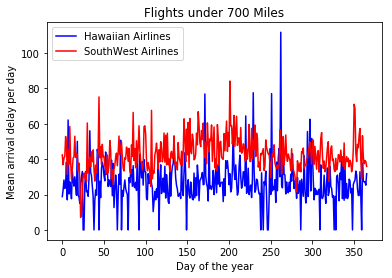

In [24]:
plt.plot(hawii_list,color='b')
plt.plot(south_list,color='r')
plt.legend(['Hawaiian Airlines','SouthWest Airlines'])
plt.xlabel('Day of the year')
plt.ylabel('Mean arrival delay per day')
plt.title('Flights under 700 Miles')
plt.show()

#### Above 700 miles distance 

In [25]:
alaska_airlines = airlines_more_700.loc[airlines_more_700['CARRIER_NAME'] == 'Alaska Airlines'].reset_index(drop=True)
southwest_airlines = airlines_more_700.loc[airlines_more_700['CARRIER_NAME'] == 'SouthWest Airlines'].reset_index(drop=True)


alaska_airlines = alaska_airlines.groupby('FL_DATE')['ARR_DELAY'].mean().reset_index()
southwest_airlines = southwest_airlines.groupby('FL_DATE')['ARR_DELAY'].mean().reset_index()

alaska_airlines['FL_DATE'] = pd.to_datetime(alaska_airlines['FL_DATE'])
southwest_airlines['FL_DATE'] = pd.to_datetime(southwest_airlines['FL_DATE'])

In [26]:
alaska_list , south_list = getCommonDates2(alaska_airlines,southwest_airlines)

In [27]:
wald = findWaldtest(np.mean(alaska_list),
                    np.mean(south_list),np.var(alaska_list),
                    np.var(south_list),len(alaska_list), len(south_list))

In [28]:
print ("wald :", wald)
print ("critical value :",1.645)
print ("We reject the null hypothesis")

wald : 5.488111768392588
critical value : 1.645
We reject the null hypothesis


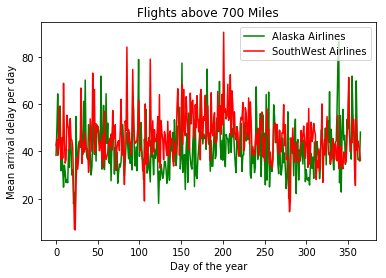

In [29]:
plt.plot(alaska_list,color='g')
plt.plot(south_list,color='r')
plt.legend(['Alaska Airlines','SouthWest Airlines'])
plt.xlabel('Day of the year')
plt.ylabel('Mean arrival delay per day')
plt.title('Flights above 700 Miles')
plt.show()

### Hypothesis 3: Rate of cancellation of flights is uniform across the day.  

In [30]:
data = pd.read_csv('flight_delay_prediction/Data/flight_delays_2016.csv','r', delimiter=',')
data = data.drop(['Unnamed: 0'],axis = 1)
ln_can = data.loc[(data['DEP_TIME']>=0.0) & (data['DEP_TIME']<=400.0) & (data['CANCELLED']!=0) & 
        ((data['MONTH'] == 3)|(data['MONTH'] == 4)|(data['MONTH'] == 5))
         & (data['ORIGIN'] == 'JFK')]
ln_mean = len(ln_can.index)/31

ln_can['NF'] = np.nan
ln_can = ln_can.fillna(1)
x = ln_can.groupby(['DAY_OF_MONTH'])['NF'].sum()

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
l = {}
for i,val in x.iteritems():
    l[i] = val

In [33]:
l2 = []
for i in range(31):
    if i in l.keys():
        l2.append(l[i])
    else:
        l2.append(0)
ln_var = np.var(l2)

In [34]:
em_can = data.loc[(data['DEP_TIME']>400.0) & (data['DEP_TIME']<=800.0) & (data['CANCELLED']!=0) &
        ((data['MONTH'] == 3)|(data['MONTH'] == 4)|(data['MONTH'] == 5))
         & (data['ORIGIN'] == 'JFK')]

em_mean = len(em_can.index)/31

em_can['NF'] = np.nan
em_can = em_can.fillna(1)
x = em_can.groupby(['DAY_OF_MONTH'])['NF'].sum()

In [35]:
l = {}
for i,val in x.iteritems():
    l[i] = val
l2 = []
for i in range(31):
    if i in l.keys():
        l2.append(l[i])
    else:
        l2.append(0)
em_var = np.var(l2)

In [36]:
m_can = data.loc[(data['DEP_TIME']>800.0) & (data['DEP_TIME']<=1200.0) & (data['CANCELLED']!=0) & 
        ((data['MONTH'] == 3)|(data['MONTH'] == 4)|(data['MONTH'] == 5))
         & (data['ORIGIN'] == 'JFK')]

m_mean = len(m_can.index)/31

m_can['NF'] = np.nan
m_can = m_can.fillna(1)
x = m_can.groupby(['DAY_OF_MONTH'])['NF'].sum()

In [37]:
l = {}
for i,val in x.iteritems():
    l[i] = val
l2 = []
for i in range(31):
    if i in l.keys():
        l2.append(l[i])
    else:
        l2.append(0)
m_var = np.var(l2)

In [39]:
a_can = data.loc[(data['DEP_TIME']>1200.0) & (data['DEP_TIME']<=1600.0) & (data['CANCELLED']!=0) &
        ((data['MONTH'] == 3)|(data['MONTH'] == 4)|(data['MONTH'] == 5))
         & (data['ORIGIN'] == 'JFK')]

a_mean = len(m_can.index)/31

a_can['NF'] = np.nan
a_can = a_can.fillna(1)
x = a_can.groupby(['DAY_OF_MONTH'])['NF'].sum()

In [40]:
l = {}
for i,val in x.iteritems():
    l[i] = val
l2 = []
for i in range(31):
    if i in l.keys():
        l2.append(l[i])
    else:
        l2.append(0)
a_var = np.var(l2)

e_can = data.loc[(data['DEP_TIME']>1600.0) & (data['DEP_TIME']<=2000.0) & (data['CANCELLED']!=0) & 
        ((data['MONTH'] == 3)|(data['MONTH'] == 4)|(data['MONTH'] == 5))
         & (data['ORIGIN'] == 'JFK')]

e_mean = len(m_can.index)/31

e_can['NF'] = np.nan
e_can = e_can.fillna(1)
x = e_can.groupby(['DAY_OF_MONTH'])['NF'].sum()

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
l = {}
for i,val in x.iteritems():
    l[i] = val
l2 = []
for i in range(31):
    if i in l.keys():
        l2.append(l[i])
    else:
        l2.append(0)
e_var = np.var(l2)

n_can = data.loc[(data['DEP_TIME']>2000.0) & (data['DEP_TIME']<=2400.0) & (data['CANCELLED']!=0) &
        ((data['MONTH'] == 3)|(data['MONTH'] == 4)|(data['MONTH'] == 5))
         & (data['ORIGIN'] == 'JFK')]
n_mean = len(m_can.index)/31
n_can['NF'] = np.nan
n_can = n_can.fillna(1)
x = n_can.groupby(['DAY_OF_MONTH'])['NF'].sum()

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
l = {}
for i,val in x.iteritems():
    l[i] = val
l2 = []
for i in range(31):
    if i in l.keys():
        l2.append(l[i])
    else:
        l2.append(0)
n_var = np.var(l2)

In [43]:
def wald(m1,m2,v1,v2):
    wald_statistic = (abs(m1-m2))/(m.sqrt((v1/31) + (v2/31)))
    return wald_statistic

In [45]:
# late night vs early morning
wald(ln_mean,em_mean,ln_var,em_var)

5.632802102863734

In [46]:
# late night vs  morning
wald(ln_mean,m_mean,ln_var,m_var)

5.632802102863734

In [47]:
# late night vs  afternoon
wald(ln_mean,a_mean,ln_var,a_var)

5.632802102863734

In [48]:
# late night vs  evening
wald(ln_mean,e_mean,ln_var,e_var)

5.380573000432567

In [49]:
# late night vs  evening
wald(ln_mean,e_mean,ln_var,e_var)

5.380573000432567